# setup

In [1]:
from pprint import pprint

import cv2
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors

from utils.images import show_image

IN = '../data/opencv_color_segmentation/IN'
OUT = '../data/opencv_color_segmentation/OUT'

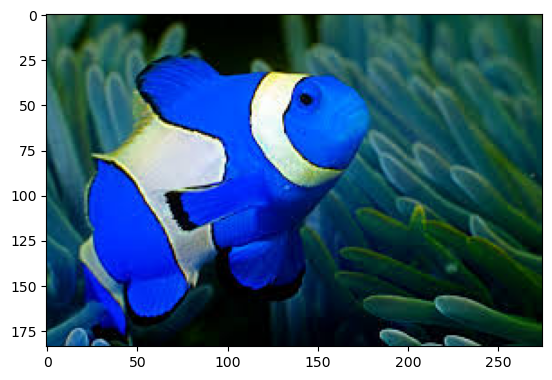

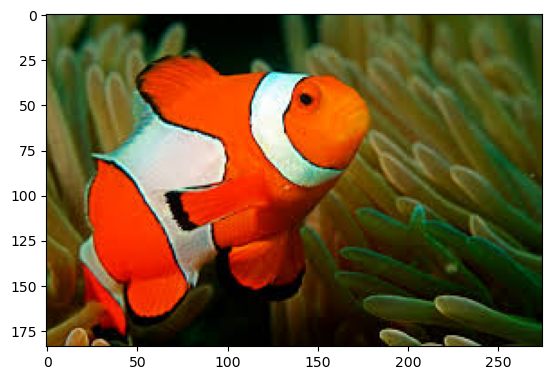

In [2]:
nemo = cv2.imread(f'{IN}/nemo0.jpg')
plt.imshow(nemo)
plt.show()

nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)
plt.show()


# 3D plot (RGB)


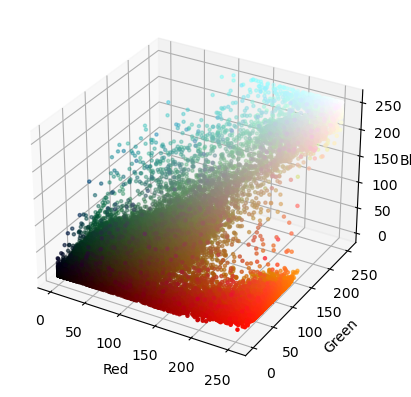

In [3]:
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((-1, 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()


# 3D plot (HSV)

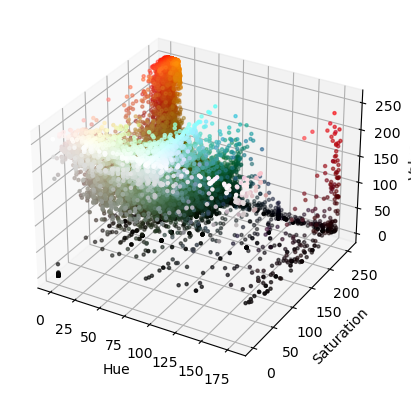

In [4]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()


# 3D - my generalized function


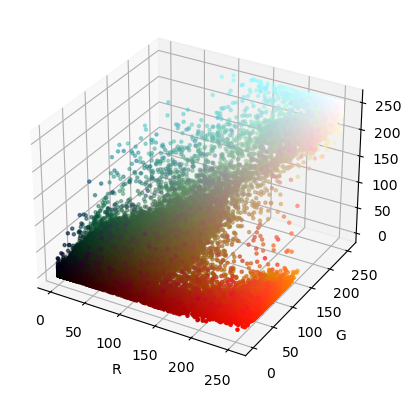

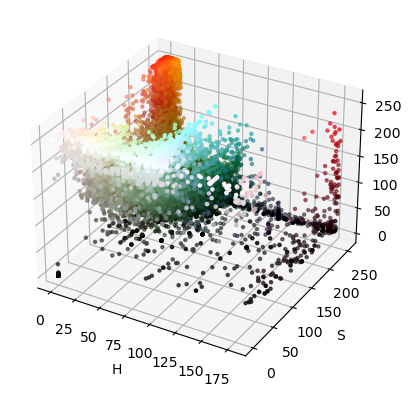

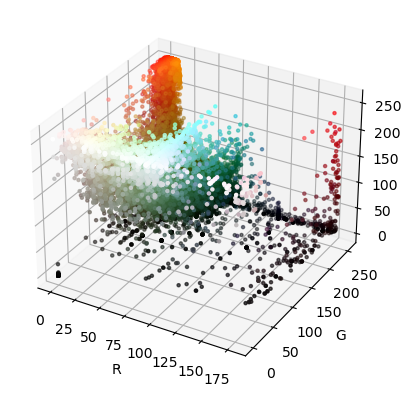

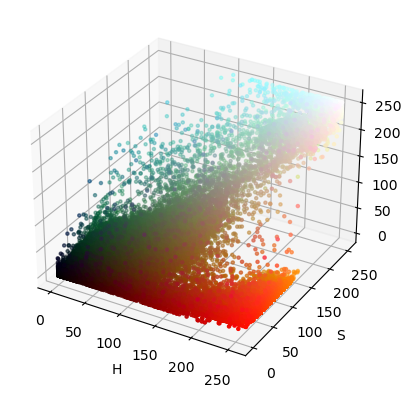

In [5]:
def plot_3D(image, original, target=None):
    target = target or original
    if target == original == 'RGB':
        image_rgb = image
    elif target == original == 'HSV':
        image_rgb = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    elif original == 'HSV' and target == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        image_rgb = image
    elif original == 'RGB' and target == 'HSV':
        image_rgb = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    else:
        raise ValueError(f'original={original!r}, target={target!r}')

    pixel_colors = get_facecolors(image_rgb)
    channels = [ch.flatten() for ch in cv2.split(image)]
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(*channels, facecolors=pixel_colors, marker=".")
    axis.set_xlabel(original[0])
    axis.set_ylabel(original[1])
    axis.set_zlabel(original[2])
    plt.show()


def get_facecolors(image_rgb):
    pixel_colors = image_rgb.reshape((-1, 3))
    norm = colors.Normalize(vmin=-1., vmax=1.)
    norm.autoscale(pixel_colors)
    return norm(pixel_colors).tolist()


plot_3D(nemo, 'RGB')
plot_3D(hsv_nemo, 'HSV')
plot_3D(nemo, 'RGB', 'HSV')
plot_3D(hsv_nemo, 'HSV', 'RGB')


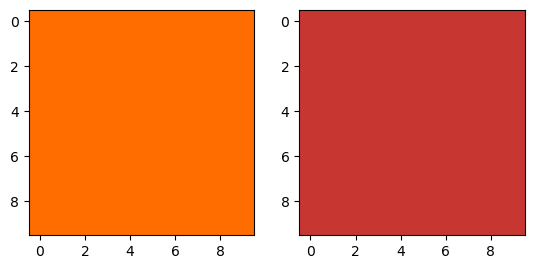

In [6]:
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)
lo_square = np.full((10, 10, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_orange, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(colors.hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(colors.hsv_to_rgb(lo_square))
plt.show()


# segmenting nemo (orange only)

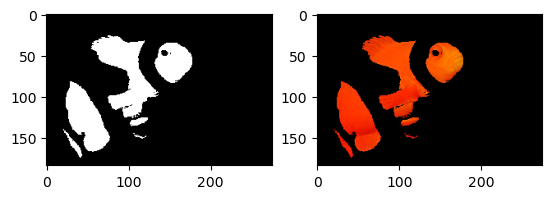

In [8]:
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()


# segmenting nemo (orange and white)

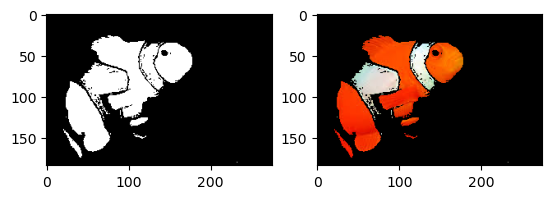

In [13]:
light_white = (0, 0, 200)
dark_white = (145, 60, 255)
mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)

final_mask = mask + mask_white
final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

# blur to remove FPs


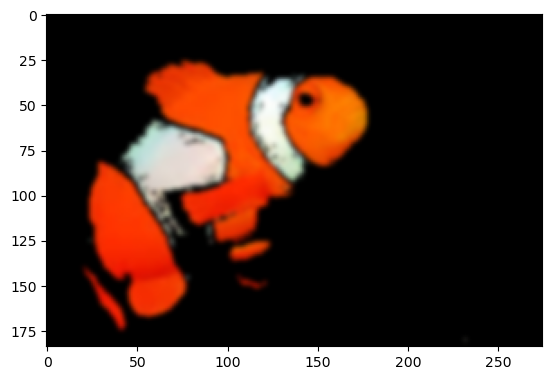

In [14]:
blur = cv2.GaussianBlur(final_result, (7, 7), 0)
plt.imshow(blur)
plt.show()


# Does This Segmentation Generalize to Nemo’s Relatives?


In [15]:
def segment_fish(image):
    """Attempts to segment the clownfish out of the provided image"""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    light_orange = (1, 190, 200)
    dark_orange = (18, 255, 255)
    mask = cv2.inRange(hsv_image, light_orange, dark_orange)

    light_white = (0, 0, 200)
    dark_white = (145, 60, 255)
    mask_white = cv2.inRange(hsv_image, light_white, dark_white)

    final_mask = mask + mask_white
    result = cv2.bitwise_and(image, image, mask=final_mask)
    return cv2.GaussianBlur(result, (7, 7), 0)

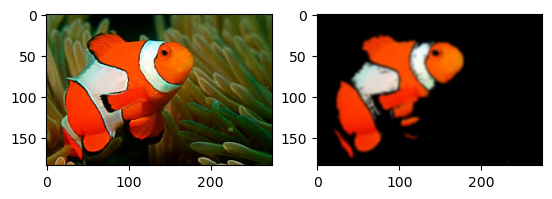

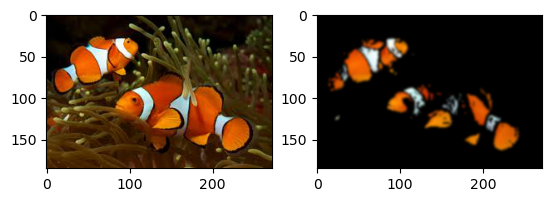

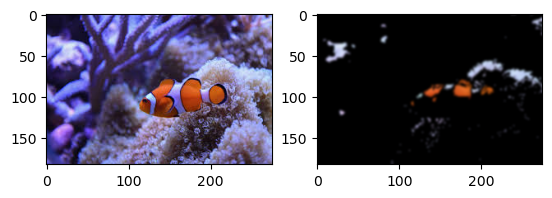

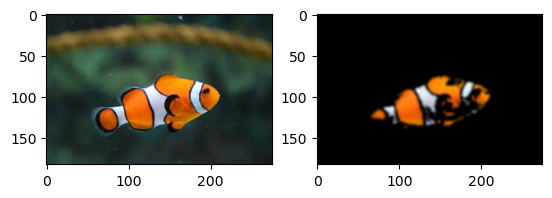

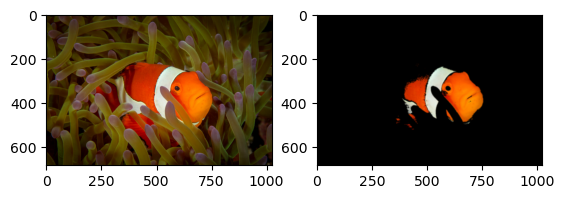

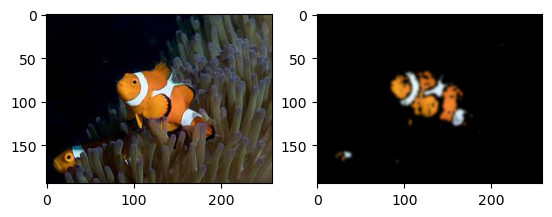

In [18]:
prefix = f'{IN}/nemo'

nemos_friends = (cv2.imread(f'{prefix}{i}.jpg') for i in range(6))
nemos_friends = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in nemos_friends]
segmented = (segment_fish(img) for img in nemos_friends)

for original, final in zip(nemos_friends, segmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.imshow(final)
    plt.show()
